# How to approach remote data - A NFDI4Cat use case.

## Introduction

Working with partners in a joined project can very often have challenges. This is especially true when work packages have interfaces to other ones. In [NFDI4Cat](https://doi.org/10.1002/cctc.202001974) the challenge is to work data across a consortium. To enhance this processs especially also for teaching purposes data provided by partners was wrapped into a package in order to facilitate its usage and to get started with the process of data analytic.

## Basic data inspection on the BasCat provided perfomance data set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### The tools used

In this work several tools will be used. The most important thing is Python which is used for all computations. As an interface to the Python interpreter JupyterLab is used which gives a modern user interface within the browser. In order to create a plain text format out of the Jupyter notebook Jupytext is used in order to reduce the less relevant meta information in the notebook. Special libraries used will be discussed when they are used in the data analysis.

### Importing the dataset from the Dataverse instance

The data storage pilot instance for NFDI4Cat and in the future probably the whole catalysis community in Germany is installed with help of Fraunhofer Fokus as a [Dataverse instance](https://dataverse.org/). To get an initial glimpse on the data in the repository we created a helper package that provides the dataset in a scikit-learn like fashion. For further instructions also compare the Readme file in the data4cat repository.

## Download and basic inspection

In order to first download the dataset we use the data4cat package. The requests calls used to communicate with the Dataverse REST API are hidden in this package for convenience.

In [2]:
from data4cat import dino_run

In [3]:
dinodat = dino_run.dino_offline()

Instance created


The next is a representation of the data available online.

In [4]:
original_data = dinodat.original_data()
original_data.head()

,Clock,Experiment,xCO,xH2,Temperature,Vflow,Pressure,TOS,Reactor,X_CO,...,S_Butanal,S_Acetic acid,S_Methyl acetate,S_Ethyl acetate,S_Unknown,S_CO2,S_C2_oxy,S_C2_p_oxy,S_C2_p_HCs,C-balance
0,"01-07-2020 20:11:45,85",1,0.2,0.6,260,41.7,54,4,1,12.80,...,0.65,11.63,0.22,0.55,0,0.34,22.05,22.82,15.66,94.821057
1,"01-07-2020 23:40:47,85",1,0.2,0.6,260,41.7,54,8,1,10.34,...,0.62,12.90,0.30,0.63,0,0.49,24.33,25.26,14.85,93.196889
2,"02-07-2020 03:09:42,85",1,0.2,0.6,260,41.7,54,11,1,9.42,...,0.60,14.08,0.37,0.69,0,0.58,26.24,27.30,14.13,96.114929
3,"02-07-2020 06:38:32,85",1,0.2,0.6,260,41.7,54,15,1,8.39,...,0.58,14.61,0.41,0.77,0,0.64,27.25,28.43,13.65,93.683447
4,"02-07-2020 10:07:29,85",1,0.2,0.6,260,41.7,54,18,1,8.10,...,0.57,14.81,0.46,0.78,0,0.69,27.95,29.19,13.60,97.105808


The first experiment, which runs until ~85h can be used to observe stabilization behavior of catalysts, in terms of CO conversion (X_CO). This can be seen in the following visualization.

In [5]:
startup_data = dinodat.startup_data()
startup_data.tail()

,TOS,X_CO,Reactor
232,70,0.08,5
233,73,0.08,5
234,77,0.08,5
235,80,0.08,5
236,84,0.08,5


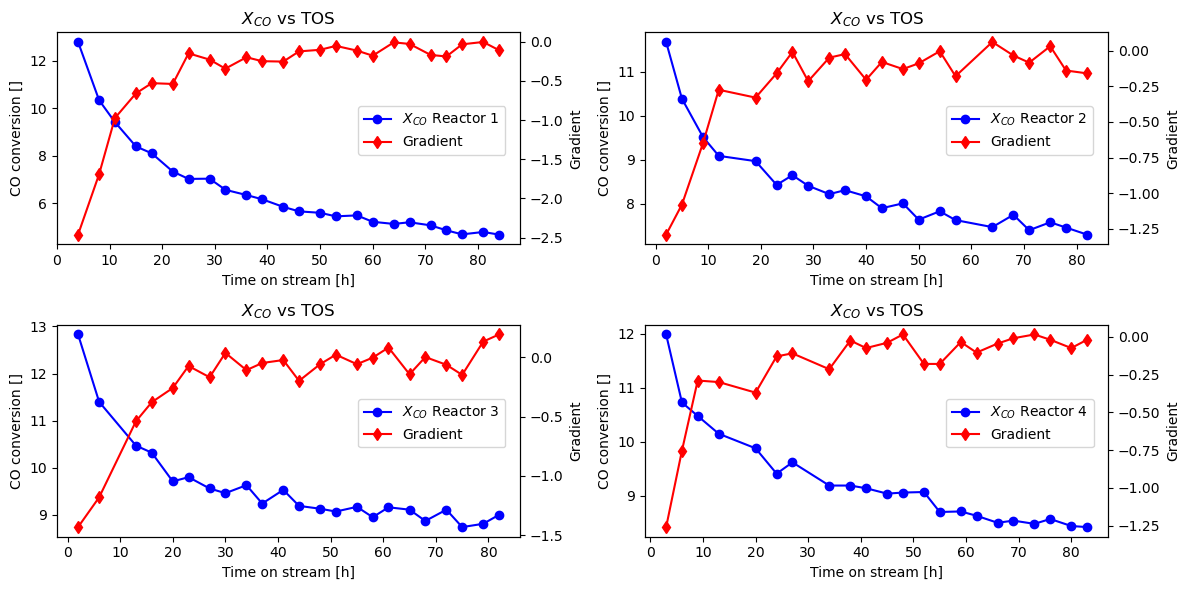

In [6]:
fig = plt.figure(figsize=(12,6))
for entry in [1,2,3,4]:
    
    filtered_by_reactor = startup_data[startup_data['Reactor']== entry]  
    
    ax1 = fig.add_subplot(2,2,entry)
    ax1.set_title(r'$X_{CO}$ vs TOS')
    ax1.set_xlabel('Time on stream [h]')
    ax1.set_ylabel('CO conversion []')
    left, = ax1.plot(filtered_by_reactor['TOS'], filtered_by_reactor['X_CO'],'bo-')
    
    ax2 = ax1.twinx()
    right, = ax2.plot(filtered_by_reactor['TOS'], np.gradient(filtered_by_reactor['X_CO']),'rd-')
    ax2.set_ylabel('Gradient')
    ax1.legend([left, right], ['$X_{CO}$ Reactor '+ str(entry),'Gradient'], bbox_to_anchor=(0.65, 0.65), loc=2, borderaxespad=0.)
    fig.tight_layout();

For further analysis unsupervised and supervised learning will be used. We therefore need different representations of the data. The selectivity matrix will be used as features (x-values). The reactor numbering will be used as initial "clusters" (y-values).

In [7]:
X, clusters = dinodat.selectivity()
X.head()

,S_Methane,S_Ethane,S_Propane,S_n-Butane,S_nC5,S_nC6,S_Ethylene,S_Propylene,S_n-Butene,S_C5-1,...,S_Acetaldehyde,S_Propanal,S_Butanal,S_Acetic acid,S_Methyl acetate,S_Ethyl acetate,S_Unknown,S_CO2,S_C2_oxy,S_C2_p_oxy
0,59.56,4.97,6.46,2.02,0.81,0.37,0.0,0.88,0.15,0,...,7.54,0.71,0.65,11.63,0.22,0.55,0,0.34,22.05,22.82
1,57.86,4.74,5.92,1.84,0.76,0.34,0.0,1.10,0.15,0,...,8.11,0.71,0.62,12.90,0.30,0.63,0,0.49,24.33,25.26
2,56.43,4.61,5.60,1.73,0.73,0.34,0.0,0.98,0.14,0,...,8.52,0.71,0.60,14.08,0.37,0.69,0,0.58,26.24,27.30
3,55.75,4.49,5.36,1.66,0.71,0.26,0.0,1.02,0.15,0,...,8.78,0.70,0.58,14.61,0.41,0.77,0,0.64,27.25,28.43
4,55.00,4.43,5.23,1.61,0.69,0.29,0.0,1.20,0.15,0,...,9.06,0.69,0.57,14.81,0.46,0.78,0,0.69,27.95,29.19


## Unsupervised Learning

First we do some dimensional reduction for the 25 dimensional feature matrix X. For this the PCA and the t-SNE algorithm are used. A random seed is used to enhance deterministic results.

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

np.random.seed(42)

In [9]:
pca = PCA(n_components=2).fit_transform(X)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X)

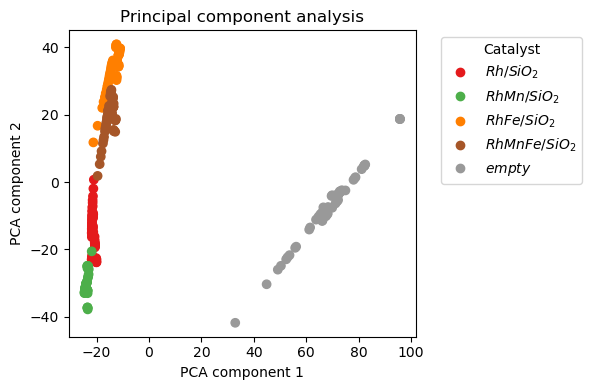

In [10]:
title = 'Catalyst'
labels = [r'$Rh/SiO_2$',r'$RhMn/SiO_2$',r'$RhFe/SiO_2$',r'$RhMnFe/SiO_2$',r'$empty$']

fig, ax = plt.subplots(figsize=(7,4))
plt.title('Principal component analysis')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
scatterplot = ax.scatter(pca[:,0], pca[:,1], c=clusters, cmap=cm.Set1)
ax.legend(handles=scatterplot.legend_elements()[0],labels=labels, title=title, bbox_to_anchor=(1.5, 1.0))
plt.tight_layout();

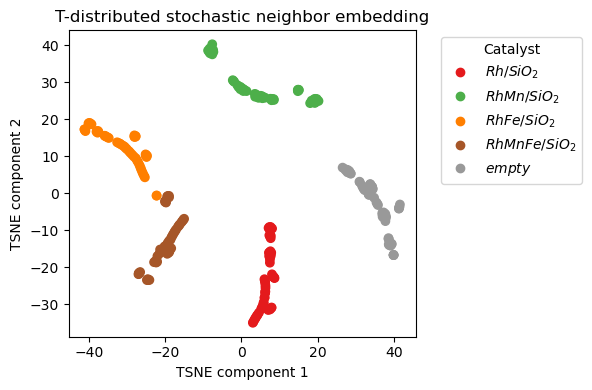

In [11]:
title = 'Catalyst'
labels = [r'$Rh/SiO_2$',r'$RhMn/SiO_2$',r'$RhFe/SiO_2$',r'$RhMnFe/SiO_2$',r'$empty$']

fig, ax = plt.subplots(figsize=(7,4))
plt.title('T-distributed stochastic neighbor embedding')
plt.xlabel('TSNE component 1')
plt.ylabel('TSNE component 2')
scatterplot = ax.scatter(tsne[:,0], tsne[:,1], c=clusters, cmap=cm.Set1)
ax.legend(handles=scatterplot.legend_elements()[0],labels=labels, title=title, bbox_to_anchor=(1.5, 1.0))
plt.tight_layout();

The overall initial inspection of the data show that we should remove the empty reactor from the dataset. The dimensional reduction shows 5 clusters which can be identified by the reactor tubes.

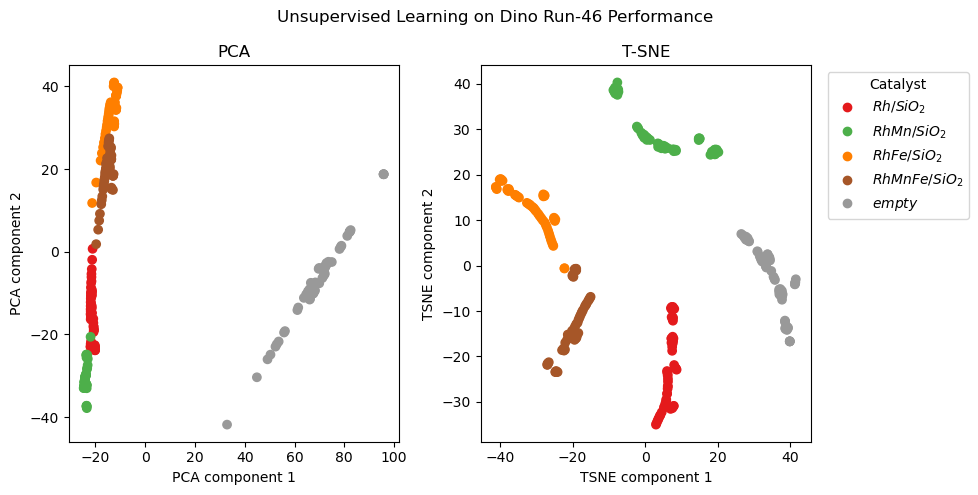

In [12]:
title = 'Catalyst'
labels = [r'$Rh/SiO_2$',r'$RhMn/SiO_2$',r'$RhFe/SiO_2$',r'$RhMnFe/SiO_2$',r'$empty$']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Unsupervised Learning on Dino Run-46 Performance')

ax1.set_title('PCA')
ax1.set_xlabel('PCA component 1')
ax1.set_ylabel('PCA component 2')
scatterplot1 = ax1.scatter(pca[:,0], pca[:,1], c=clusters, cmap=cm.Set1)

ax2.set_title('T-SNE')
ax2.set_xlabel('TSNE component 1')
ax2.set_ylabel('TSNE component 2')
scatterplot2 = ax2.scatter(tsne[:,0], tsne[:,1], c=clusters, cmap=cm.Set1)

ax2.legend(handles=scatterplot2.legend_elements()[0],labels=labels, title=title, bbox_to_anchor=(1.5, 1.0))

plt.tight_layout();

We therefore have to filter the empty reactor from the dataset. The data4cat package as an included argument for this. We now create a new feature matrix and "clusters".

In [13]:
X_filtered, clusters = dinodat.selectivity(r5=False)
X_filtered.head()

,S_Methane,S_Ethane,S_Propane,S_n-Butane,S_nC5,S_nC6,S_Ethylene,S_Propylene,S_n-Butene,S_C5-1,...,S_Acetaldehyde,S_Propanal,S_Butanal,S_Acetic acid,S_Methyl acetate,S_Ethyl acetate,S_Unknown,S_CO2,S_C2_oxy,S_C2_p_oxy
0,59.56,4.97,6.46,2.02,0.81,0.37,0.0,0.88,0.15,0,...,7.54,0.71,0.65,11.63,0.22,0.55,0,0.34,22.05,22.82
1,57.86,4.74,5.92,1.84,0.76,0.34,0.0,1.10,0.15,0,...,8.11,0.71,0.62,12.90,0.30,0.63,0,0.49,24.33,25.26
2,56.43,4.61,5.60,1.73,0.73,0.34,0.0,0.98,0.14,0,...,8.52,0.71,0.60,14.08,0.37,0.69,0,0.58,26.24,27.30
3,55.75,4.49,5.36,1.66,0.71,0.26,0.0,1.02,0.15,0,...,8.78,0.70,0.58,14.61,0.41,0.77,0,0.64,27.25,28.43
4,55.00,4.43,5.23,1.61,0.69,0.29,0.0,1.20,0.15,0,...,9.06,0.69,0.57,14.81,0.46,0.78,0,0.69,27.95,29.19


Next we do a new PCA and t-SNE with the reduced dataset.

In [14]:
pca = PCA(n_components=2).fit_transform(X_filtered)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X_filtered)

Again the dataset can be distiguished by the reactor/catalyst.

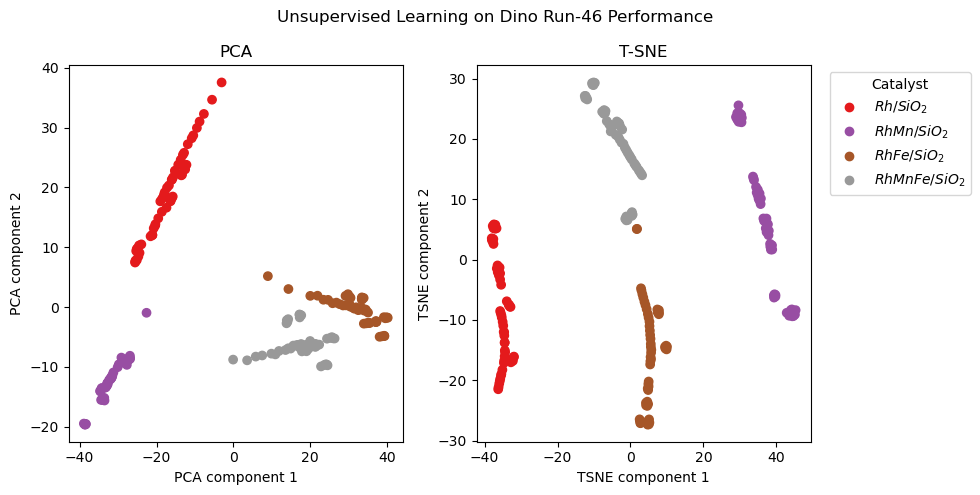

In [15]:
title = 'Catalyst'
labels = [r'$Rh/SiO_2$',r'$RhMn/SiO_2$',r'$RhFe/SiO_2$',r'$RhMnFe/SiO_2$']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Unsupervised Learning on Dino Run-46 Performance')

ax1.set_title('PCA')
ax1.set_xlabel('PCA component 1')
ax1.set_ylabel('PCA component 2')
scatterplot1 = ax1.scatter(pca[:,0], pca[:,1], c=clusters, cmap=cm.Set1)

ax2.set_title('T-SNE')
ax2.set_xlabel('TSNE component 1')
ax2.set_ylabel('TSNE component 2')
scatterplot2 = ax2.scatter(tsne[:,0], tsne[:,1], c=clusters, cmap=cm.Set1)

ax2.legend(handles=scatterplot2.legend_elements()[0],labels=labels, title=title, bbox_to_anchor=(1.5, 1.0))

plt.tight_layout()

For further insights the reactor tube is replaced by that catalyst composition. This also exists in data4cat for convenience.

In [16]:
X, y = dinodat.react_cond(r5=False)

This leads to a reduced dataset with all the setpoints as features and the selectivity to ethanol as target.

In [17]:
X.head()

,xCO,xH2,Temperature,Vflow,Pressure,TOS,X_CO,X_H2,Rh,Mn,Fe
0,0.2,0.6,260,41.7,54,4,12.80,25.60,2.12,0.0,0.0
1,0.2,0.6,260,41.7,54,8,10.34,29.08,2.12,0.0,0.0
2,0.2,0.6,260,41.7,54,11,9.42,23.78,2.12,0.0,0.0
3,0.2,0.6,260,41.7,54,15,8.39,27.11,2.12,0.0,0.0
4,0.2,0.6,260,41.7,54,18,8.10,19.38,2.12,0.0,0.0


Now we can also cluster by the Rh content. It seems like the catalyst composition has definitely some impact on the data.

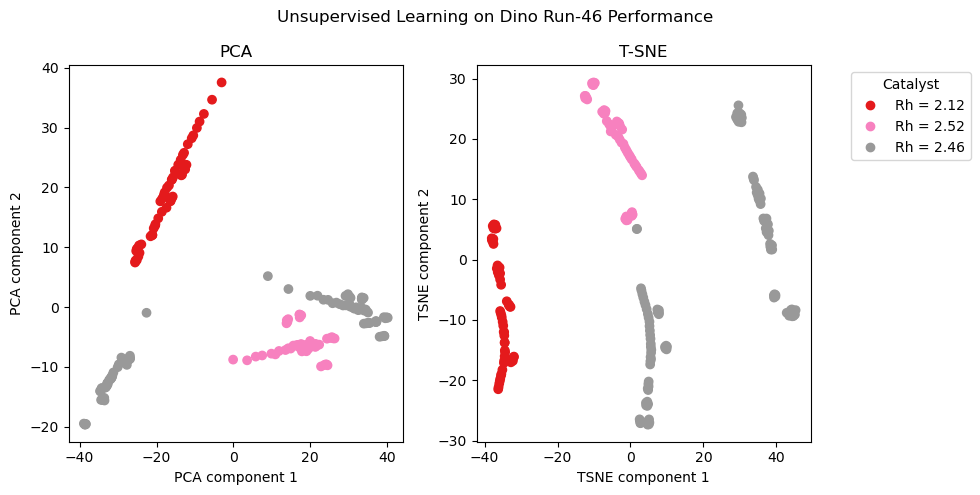

In [18]:
title = 'Catalyst'
labels = ['Rh = 2.12', 'Rh = 2.52', 'Rh = 2.46']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Unsupervised Learning on Dino Run-46 Performance')

ax1.set_title('PCA')
ax1.set_xlabel('PCA component 1')
ax1.set_ylabel('PCA component 2')
scatterplot1 = ax1.scatter(pca[:,0], pca[:,1], c=X['Rh'], cmap=cm.Set1)

ax2.set_title('T-SNE')
ax2.set_xlabel('TSNE component 1')
ax2.set_ylabel('TSNE component 2')
scatterplot2 = ax2.scatter(tsne[:,0], tsne[:,1], c=X['Rh'], cmap=cm.Set1)

ax2.legend(handles=scatterplot2.legend_elements()[0],labels=labels, title=title, bbox_to_anchor=(1.5, 1.0))

plt.tight_layout();

The initial clustering will now be complemented with clustering that does not now anything about the reactor setup. We use the Kmeans algorithm for this purpose.

In [19]:
from sklearn.cluster import KMeans

In [20]:
k_ellbow = []
for E in range(20):
    E = E+1
    kmeans = KMeans(n_clusters=E, n_init='auto')
    kmeans.fit(X_filtered)
    score = kmeans.score(X_filtered)
    k_ellbow.append(score)

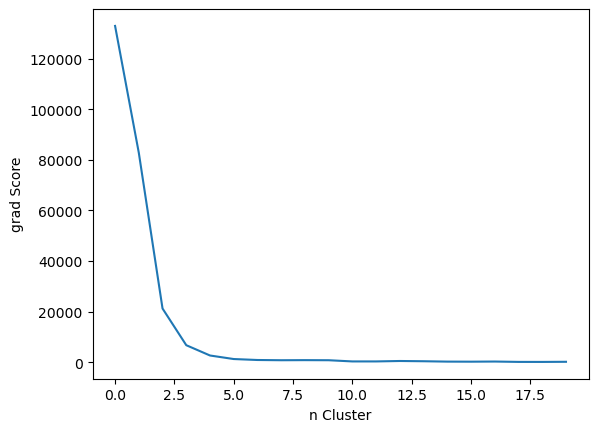

In [21]:
plt.plot(np.gradient(k_ellbow))
plt.xlabel('n Cluster')
plt.ylabel('grad Score');

In [22]:
k_cluster = KMeans(n_clusters=4, n_init='auto')
k_cluster.fit(X_filtered)
y_k_cluster = k_cluster.predict(X_filtered)

Also when doing a completely unsupervised clustering the same clusters can be identified which are the same as the reactors/catalysts.

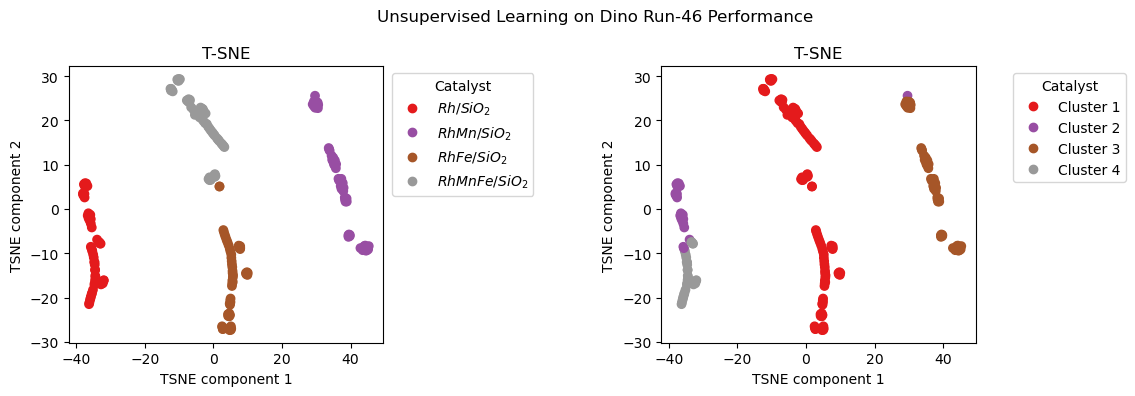

In [23]:
title = 'Catalyst'
labels = [r'$Rh/SiO_2$',r'$RhMn/SiO_2$',r'$RhFe/SiO_2$',r'$RhMnFe/SiO_2$']
labels1 = ['Rh = 2.12', 'Rh = 2.52', 'Rh = 2.46']
labels2 = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle('Unsupervised Learning on Dino Run-46 Performance')

ax1.set_title('T-SNE')
ax1.set_xlabel('TSNE component 1')
ax1.set_ylabel('TSNE component 2')
scatterplot1 = ax1.scatter(tsne[:,0], tsne[:,1], c=clusters, cmap=cm.Set1)

ax2.set_title('T-SNE')
ax2.set_xlabel('TSNE component 1')
ax2.set_ylabel('TSNE component 2')
scatterplot2 = ax2.scatter(tsne[:,0], tsne[:,1], c=y_k_cluster, cmap=cm.Set1)

ax1.legend(handles=scatterplot1.legend_elements()[0],labels=labels, title=title, bbox_to_anchor=(1.5, 1.0))
ax2.legend(handles=scatterplot2.legend_elements()[0],labels=labels2, title=title, bbox_to_anchor=(1.5, 1.0))

plt.tight_layout();

## Supervised learning

Next supervised learning will be used to find more dependencies within the data. We choose a Random Forest Regressor to watch out for those dependencies.

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [25]:
X.head()

,xCO,xH2,Temperature,Vflow,Pressure,TOS,X_CO,X_H2,Rh,Mn,Fe
0,0.2,0.6,260,41.7,54,4,12.80,25.60,2.12,0.0,0.0
1,0.2,0.6,260,41.7,54,8,10.34,29.08,2.12,0.0,0.0
2,0.2,0.6,260,41.7,54,11,9.42,23.78,2.12,0.0,0.0
3,0.2,0.6,260,41.7,54,15,8.39,27.11,2.12,0.0,0.0
4,0.2,0.6,260,41.7,54,18,8.10,19.38,2.12,0.0,0.0


In [26]:
y.head()

0    2.88
1    3.32
2    3.64
3    3.86
4    4.08
Name: S_Ethanol, dtype: float64

In [27]:
names = X.columns

In [28]:
forest = RandomForestRegressor()
forest.fit(X, y)

RandomForestRegressor()

In [29]:
importances = forest.feature_importances_

Looking at the feature importance clearly shows that the selectivity is governed by the Rh content and a little bit by the TOS. The rest of the features do not play a big role.

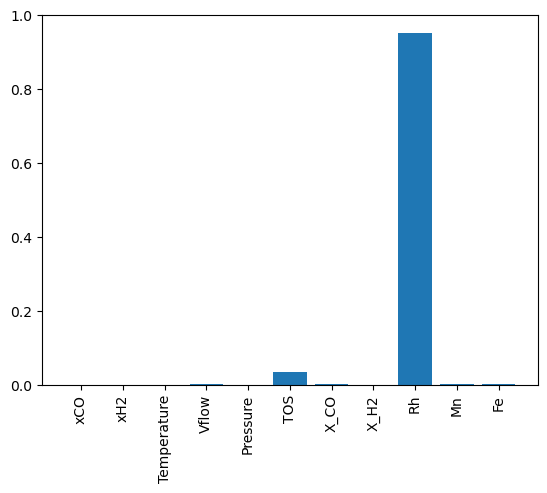

In [30]:
plt.xticks(rotation = 90)
plt.bar(x=names, height=importances);

This can also be expressed via the next two pictures.

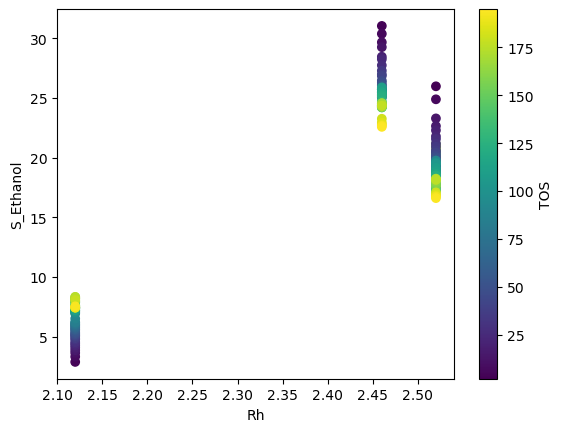

In [31]:
plt.xlabel('Rh')
plt.ylabel('S_Ethanol')
plt.scatter(X['Rh'], y, c=X['TOS'])
plt.colorbar(label='TOS');

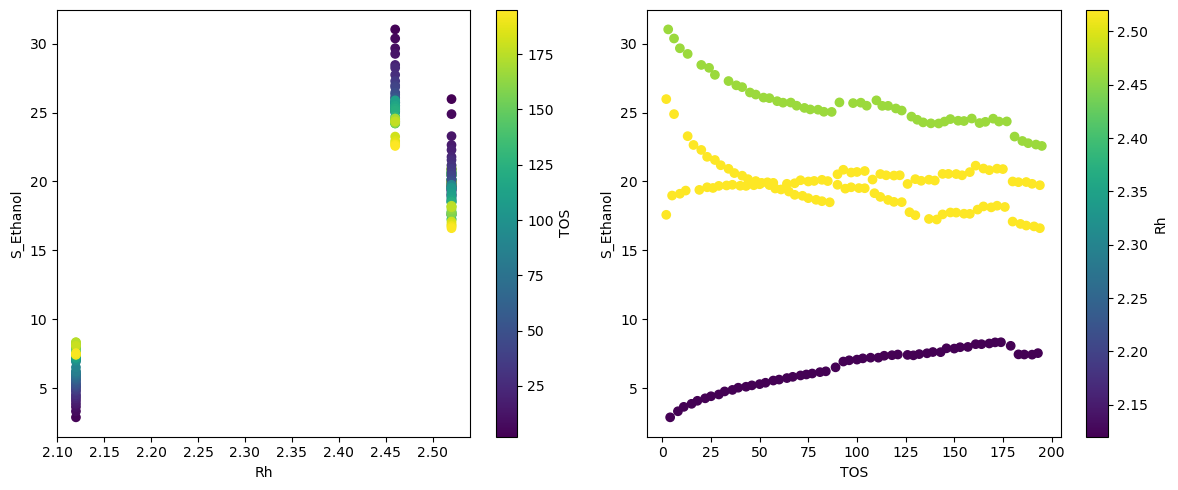

In [32]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.xlabel('Rh')
plt.ylabel('S_Ethanol')
plt.scatter(X['Rh'], y, c=X['TOS'])
plt.colorbar(label='TOS')

plt.subplot(122)
plt.xlabel('TOS')
plt.ylabel('S_Ethanol')
plt.scatter(X['TOS'], y, c=X['Rh'])
plt.colorbar(label='Rh')
plt.tight_layout();

We can use this information to normalize the ethanol selectivity by the TOS and the Rh content. This leads to the following histogram where we end up with basically the same number for all experiments.

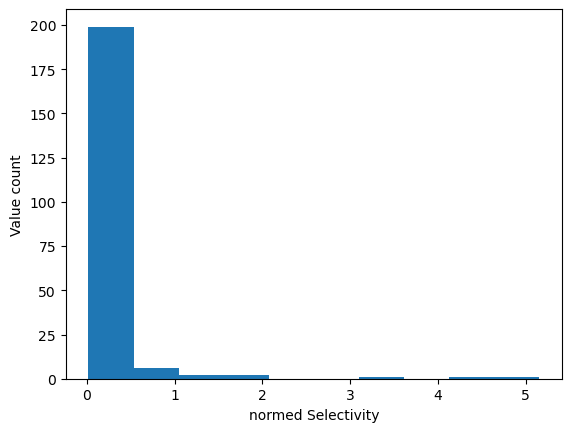

In [33]:
plt.xlabel('normed Selectivity')
plt.ylabel('Value count')
plt.hist(y/(X['TOS']*X['Rh']));

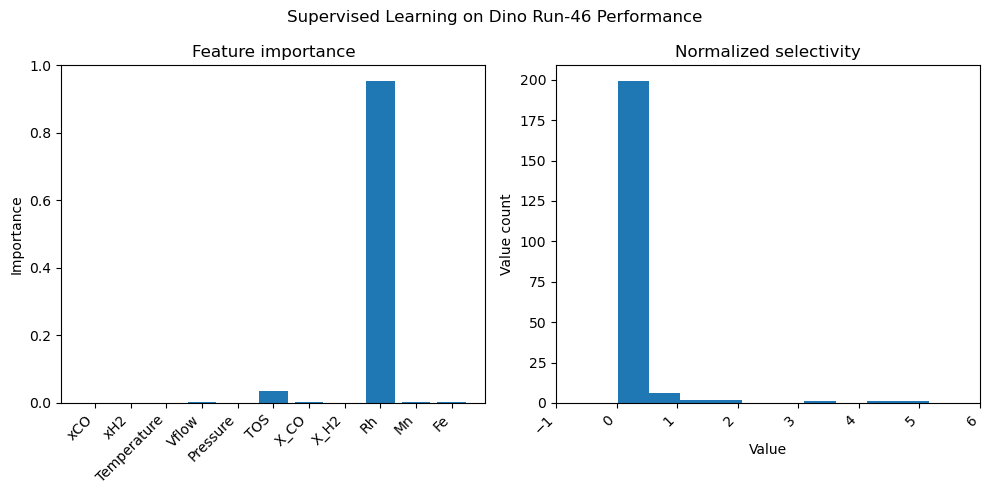

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Supervised Learning on Dino Run-46 Performance')

ax1.set_title('Feature importance')
ax1.set_ylabel('Importance')
ax1.bar(x=names, height=importances)
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

ax2.set_title('Normalized selectivity')
ax2.set_xlabel('Value')
ax2.set_ylabel('Value count')
ax2.hist(y/(X['TOS']*X['Rh']))
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout();

For reproducibility finally a requirements file is written.

In [35]:
import session_info
session_info.show(write_req_file=True, req_file_name='requirements.txt')